In [45]:
# IMPORTS AND LOADING DATA
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt

# load in data
reviews=[]
sentiment_ratings=[]
product_types=[]
helpfulness_ratings=[]

with open("Compiled_Reviews.txt") as f:
   for line in f.readlines()[1:]:
        fields = line.rstrip().split('\t')
        reviews.append(fields[0])
        sentiment_ratings.append(fields[1])
        product_types.append(fields[2])
        helpfulness_ratings.append(fields[3])


In [46]:
# LOAD IN STOPWORDS
f = open("data/stopwords.txt", "r")
stopwords = []
for line in f:
    stopwords.append(line.strip())
f.close()

punct = ['#', '"', '""', '%', '$', '&', ')', '(', '+', '*', '-'] 

In [47]:
# GET VOCABULARY - 5000 MOST COMMON WORDS

# tokenise reviews
token_def = re.compile("[^ \.?!:,)(\"]+")
tokenized_sents = [token_def.findall(txt) for txt in reviews]
tokens=[]
for s in tokenized_sents:

    filtered_tokens = [t.lower() for t in s if t.lower() not in stopwords and t not in punct]
    
    tokens.extend(filtered_tokens)
    tokens.extend([f"{filtered_tokens[i]}_{filtered_tokens[i+1]}" for i in range(len(filtered_tokens) - 1)]) 

# use a counter to count the tokens
counts=Counter(tokens)
# sort the tokens
so=sorted(counts.items(), key=lambda item: item[1], reverse=True)
so=list(zip(*so))[0]

# get 5000 most common into vocabulary
type_list=so[0:5000]
vocab_list = type_list


In [ ]:
# CREATE AN EMBEDDING MATRIX
# M = np.zeros((len(reviews), len(vocab_list)))
# print(len(reviews))
# for i, rev in enumerate(reviews):
#     if i%1000 == 0:
#          print(i)
    
#     tokens = [t for t in token_def.findall(rev)]
#     bigrams = [f"{tokens[j]}_{tokens[j+1]}" for j in range(len(tokens) - 1)]
#     all_tokens = tokens + bigrams 

#     # iterate over vocab
#     for j, vocab_token in enumerate(vocab_list):
#         # if the current word j occurs in the current review i then set the matrix element at i,j to be one. Otherwise leave as zero.
#         if vocab_token in all_tokens:
              
#               # FOR BAG OF WORDS
#               M[i, j] += 1

M = np.load("M.npy")

In [50]:
# GET TRAINING AND TESTING DATA
np.random.seed(10)
train_ints=np.random.choice(len(reviews),int(len(reviews)*0.8),replace=False)
test_ints=list(set(range(0,len(reviews))) - set(train_ints))
M_train = M[train_ints,]
M_test = M[test_ints,]

# for labels, use a vector representation
labels_train = [sentiment_ratings[i] for i in train_ints]
labels_test = [sentiment_ratings[i] for i in test_ints]


In [59]:
# DEFINING VARIABLES

# FOR BATCH TRAINING
k = 443
# Create array of all indices in training data
a=np.arange(M_train.shape[0])
# randomly shuffle indices in place (in case of classes being unequally distributed across positions in data)
np.random.shuffle(a)
# Split indices into k equal batches
batches=np.array(np.split(a, k))

# other essential variables 
y=[int(l == "positive") for l in labels_train]
y = np.array(y)
num_features=len(vocab_list)
weights = np.random.rand(num_features)
bias=np.random.rand(1)
n_iters = 6000
lr=0.225
logistic_loss=[]
num_samples=len(y)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900


Text(0, 0.5, 'loss')

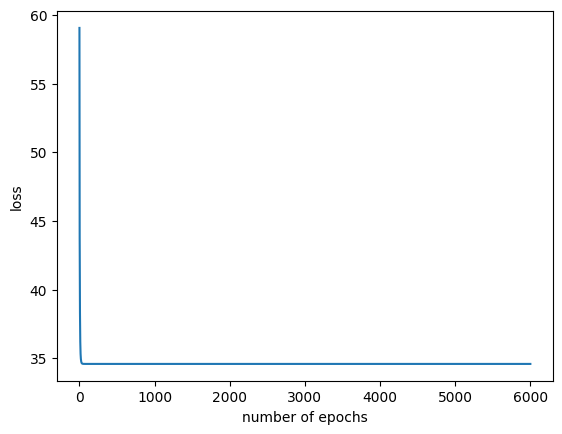

In [60]:
# RUN MODEL
for i in range(n_iters):
    if i % 100 == 0: # for logging progress
        print(i)
    
    loss = 0.0
    for j in range(len(batches)):
        this_batch_M_train = M_train[batches[j]]
        this_batch_y_train = y[batches[j]]
        z = this_batch_M_train.dot(weights.T) + bias
        q = 1/(1+np.exp(-z))

        # calculate loss
        eps=0.00001
        loss = -sum((this_batch_y_train*np.log2(q+eps)+(np.ones(len(this_batch_y_train))-this_batch_y_train)*np.log2(np.ones(len(this_batch_y_train))-q+eps)))
        

        # calculate gradients
        dw = ((q-this_batch_y_train).dot(this_batch_M_train) * (1/len(this_batch_y_train))) + (0.001*weights) 
        # dw = ((q-this_batch_y_train).dot(this_batch_M_train) * (1/len(this_batch_y_train)))
        db = sum((q-this_batch_y_train))/len(this_batch_y_train) 

        # update weights
        weights = weights - lr*dw 
        bias = bias - lr*db
    logistic_loss.append(loss)
    

plt.plot(range(1,n_iters),logistic_loss[1:])
plt.xlabel("number of epochs")
plt.ylabel("loss")
#loss = sum(-(np.ones(len(y))*np.log2(q)+(np.ones(len(y))-y)*np.log2(np.ones(len(y))-q)))

In [61]:
# EVALUATE ON TEST SET
z = M_test.dot(weights)+bias # weighted inputs
q = 1/(1+np.exp(-z)) # sigmoided input

y_test_pred = [int(prob > 0.5) for prob in q] 
y_test=[int(l == "positive") for l in labels_test]

# EVALUATION METRICS
# accuracy
acc_test=[int(yp == y_test[s]) for s,yp in enumerate(y_test_pred)]
print(f'accuracy: {sum(acc_test)/len(acc_test)}')

# precision and recall
labels_test_pred=["positive" if s == 1 else "negative" for s in y_test_pred]
true_positives=sum([int(yp == "positive" and labels_test[s] == "positive") for s,yp in enumerate(labels_test_pred)])
false_negatives=sum([int(yp == "negative" and labels_test[s] == "positive") for s,yp in enumerate(labels_test_pred)])
false_positives=sum([int(yp == "positive" and labels_test[s] == "negative") for s,yp in enumerate(labels_test_pred)])
true_negatives=sum([int(yp == "negative" and labels_test[s] == "negative") for s,yp in enumerate(labels_test_pred)])

precision = true_positives/(true_positives + false_positives)
recall = true_positives/(true_positives + false_negatives)
print(f'precision: {precision}')
print(f'recall: {recall}')

accuracy: 0.8347469220246237
precision: 0.8235945108455068
recall: 0.9005324298160697


In [62]:
# EXAMINING WEIGHTS
print("most impactful words for a positive review:")
print([vocab_list[x] for x in np.argsort(weights)[::-1][:20]])
print([vocab_list[x] for x in np.argsort(weights)[::-1][20:40]])

print("\nmost impactful words for a negative review:")
print([vocab_list[x] for x in np.argsort(weights)[:20]])
print([vocab_list[x] for x in np.argsort(weights)[20:40]])

most impactful words for a positive review:
['excellent', 'loves', 'love', 'amazing', 'perfect', 'pleased', 'best', 'great', 'easy', 'awesome', 'wonderful', 'favorite', 'perfectly', 'happy', 'satisfied', 'highly_recommend', 'price', 'delicious', 'job', 'highly']
['smooth', 'would_recommend', 'grill', 'beautiful', 'even_better', 'comfortable', 'enjoyed', 'variety', 'fun', 'sturdy', '5_stars', 'complaint', 'well', 'complaints', '4_stars', 'well_worth', 'nice', 'exactly', 'really_like', 'worry']

most impactful words for a negative review:
['worst', 'disappointed', 'waste', 'return', 'returned', 'terrible', 'poor', 'boring', 'horrible', 'disappointing', 'returning', 'useless', '2_stars', 'disappointment', 'uncomfortable', 'broke', 'poorly', 'awful', 'mistake', 'money']
['author', 'junk', 'refund', 'bad', 'barely', 'excited', 'ok', 'cannot', 'worthless', 'worse', 'dissapointed', 'guess', 'wasted', 'nothing', 'garbage', 'plastic', 'happened', 'hopes', 'mediocre', 'supposed']
